In [2]:
# Import pandas
import pandas as pd

# Load the dataset
file_path = "combined_burgerreviews_tokenised_polished.csv"
df = pd.read_csv(file_path)

# Show available columns
print("Available columns:", df.columns.tolist())


Available columns: ['place_name', 'name', 'reviewer_profile', 'rating', 'review_text', 'published_at', 'published_at_date', 'total_number_of_photos_by_reviewer', 'lowercased', 'urls_removed', 'html_removed', 'emojis_removed', 'slangs_replaced', 'punctuations_removed', 'contractions_replaced', 'price_removed', 'autocorrected', 'mm_removed', 'translated', 'stopwords_removed', 'ratings_converted', 'numbers_removed', 'lemmatized', 'tokenized', 'translated_fixed']


In [4]:
pd.set_option('display.max_colwidth', None)  # Set to None for unlimited width

print(df)

             place_name            name  \
0            Mean Mince           SW K.   
1            Mean Mince          J Soon   
2            Mean Mince  Boon Loong Leo   
3            Mean Mince   Matthew Nunis   
4            Mean Mince    Suzanne Tham   
...                 ...             ...   
1121      Spades Burger             NaN   
1122      Spades Burger             NaN   
1123      Spades Burger             NaN   
1124      Spades Burger             NaN   
1125  Woodfire Kl @ttdi             NaN   

                                                                 reviewer_profile  \
0     https://www.google.com/maps/contrib/103839925189535627667/reviews?entry=ttu   
1     https://www.google.com/maps/contrib/107730387208235308850/reviews?entry=ttu   
2     https://www.google.com/maps/contrib/104227007256556386266/reviews?entry=ttu   
3     https://www.google.com/maps/contrib/112715378443008140647/reviews?entry=ttu   
4     https://www.google.com/maps/contrib/1066597163250730

In [6]:
def fast_tokenize(text):
    if isinstance(text, str):
        return text.split()
    return []

df["tokens"] = df["stopwords_removed"].apply(fast_tokenize)
print(df["tokens"])

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                    [Love, double, smash, burger, bun, soft, patty, crisp, still, juicy, great, flavors, overall, philly, cheesesteak, also, good, generous, portion, pizza, also, generous, topping, cheese, milkshake, also, thick, water, like, places, aunt, running, place, super, friendly, Accommodating, parking, also, plentified, makes, super, plus, point, excellent, food, excellent, service, good, atmosphere]
1                                                                                                                                                        

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# Assuming your cleaned text is in this column
texts = df["stopwords_removed"].astype(str)

# Create vectorizer and transform text
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(texts)

# Check shape
print(X_bow.shape)  # (num_docs, num_unique_words)

(1126, 5104)


In [9]:
# Get list of feature words
feature_names = vectorizer.get_feature_names_out()

# Example: show top 10 words
print(feature_names[:10])


['10' '100' '11' '15' '16' '19' '1st' '20' '2019' '2020']


In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Load the dataset
df = pd.read_csv('combined_burgerreviews_tokenised_polished.csv')
# ------------------------
# 1. Bag of Words
# ------------------------
bow_vectorizer = CountVectorizer(max_features=5000)  # you can adjust max_features
bow_features = bow_vectorizer.fit_transform(texts)

# bow_features is a sparse matrix
print("BoW shape:", bow_features.shape)

# ------------------------
# 2. TF-IDF
# ------------------------
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_features = tfidf_vectorizer.fit_transform(texts)

print("TF-IDF shape:", tfidf_features.shape)


BoW shape: (1126, 5000)
TF-IDF shape: (1126, 5000)


In [14]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Apply VADER to the text
def vader_sentiment(text):
    score = analyzer.polarity_scores(text)
    return score['compound']

df['vader_score'] = texts.apply(vader_sentiment)

In [16]:
from textblob import TextBlob

# Assign sentiment based on compound score
def get_sentiment_label(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['vader_sentiment'] = df['vader_score'].apply(get_sentiment_label)

# 2. TextBlob Sentiment Analysis
def textblob_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['textblob_score'] = texts.apply(textblob_sentiment)

# Assign sentiment based on polarity
df['textblob_sentiment'] = df['textblob_score'].apply(lambda x: 'positive' if x > 0 
                                                    else 'negative' if x < 0 
                                                    else 'neutral')

In [18]:
# Create true sentiment label from score (e.g., 4-5 = pos, 1-2 = neg, 3 = neutral)
def get_label_from_score(rating):
    if rating >= 4:
        return 'positive'
    elif rating <= 2:
        return 'negative'
    else:
        return 'neutral'

df['true_sentiment'] = df['rating'].apply(get_label_from_score)

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count sentiment distributions
tb_counts = df["textblob_sentiment"].value_counts()
vader_counts = df["vader_sentiment"].value_counts()

# Print category counts
print(f"TextBlob categories: {len(tb_counts)}")
print(f"VADER categories: {len(vader_counts)}")

# Create pie charts
plt.figure(figsize=(10, 5))

TextBlob categories: 3
VADER categories: 3


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

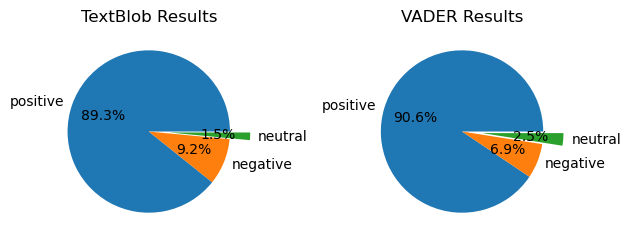

In [28]:
# TextBlob sentiment pie chart
plt.subplot(1, 2, 1)
plt.title("TextBlob Results")
tb_explode = [0] * (len(tb_counts) - 1) + [0.25]
plt.pie(tb_counts.values, labels=tb_counts.index, explode=tb_explode, autopct='%1.1f%%', shadow=False)

# VADER sentiment pie chart
plt.subplot(1, 2, 2)
plt.title("VADER Results")
vader_explode = [0] * (len(vader_counts) - 1) + [0.25]
plt.pie(vader_counts.values, labels=vader_counts.index, explode=vader_explode, autopct='%1.1f%%', shadow=False)

plt.tight_layout()
plt.savefig('sentiment_distribution_pie.png')
plt.show()

In [ ]:
# Calculate accuracy
print("Unique true_sentiment values:", df['true_sentiment'].unique())
print("Unique VADER sentiment values:", df['vader_sentiment'].unique())
print("Unique TextBlob sentiment values:", df['textblob_sentiment'].unique())


In [ ]:
# TextBlob accuracy
tb_accuracy = accuracy_score(df["true_sentiment"], df["textblob_sentiment"])
print("TextBlob Accuracy:", round(tb_accuracy * 100, 2), "%")

# Full classification report
print("TextBlob Report:")
print(classification_report(df["true_sentiment"], df["textblob_sentiment"]))

In [ ]:
# VADER accuracy
vader_accuracy = accuracy_score(df["true_sentiment"], df["vader_sentiment"])
print("VADER Accuracy:", round(vader_accuracy * 100, 2), "%")

# Full classification report
print("VADER Report:")
print(classification_report(df["true_sentiment"], df["vader_sentiment"]))

In [ ]:
# Create confusion matrices
# TextBlob Confusion Matrix
tb_cm = confusion_matrix(df["true_sentiment"], df["textblob_sentiment"], 
                         labels=["positive", "neutral", "negative"])
plt.figure(figsize=(6, 4))
sns.heatmap(tb_cm, annot=True, fmt='d', 
            xticklabels=["positive", "neutral", "negative"], 
            yticklabels=["positive", "neutral", "negative"])
plt.title("TextBlob Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('textblob_confusion_matrix.png')
plt.show()


In [ ]:
# VADER Confusion Matrix
vader_cm = confusion_matrix(df["true_sentiment"], df["vader_sentiment"], 
                           labels=["positive", "neutral", "negative"])
plt.figure(figsize=(6, 4))
sns.heatmap(vader_cm, annot=True, fmt='d', 
            xticklabels=["positive", "neutral", "negative"], 
            yticklabels=["positive", "neutral", "negative"])
plt.title("VADER Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('vader_confusion_matrix.png')
plt.show()

In [47]:
# Then you can compute accuracy
from sklearn.metrics import accuracy_score, classification_report

print("Unique true_sentiment values:", df['true_sentiment'].unique())
print("Unique VADER sentiment values:", df['vader_sentiment'].unique())
print("Unique TextBlob sentiment values:", df['textblob_sentiment'].unique())
print("Unique Naive Bayes sentiment values:", df['nb_sentiment'].unique())

print("VADER Accuracy:", accuracy_score(df['true_sentiment'], df['vader_sentiment']))
print("TextBlob Accuracy:", accuracy_score(df['true_sentiment'], df['textblob_sentiment']))
print("Naive Bayes Accuracy:", accuracy_score(df['true_sentiment'], df['nb_sentiment']))

Unique true_sentiment values: ['positive' 'neutral' 'negative']
Unique VADER sentiment values: ['positive' 'neutral' 'negative']
Unique TextBlob sentiment values: ['positive' 'negative' 'neutral']
Unique Naive Bayes sentiment values: ['positive']
VADER Accuracy: 0.7655417406749556
TextBlob Accuracy: 0.7682060390763765
Naive Bayes Accuracy: 0.7380106571936057


TextBlob categories: 3
VADER categories: 3
Naive Bayes categories: 1


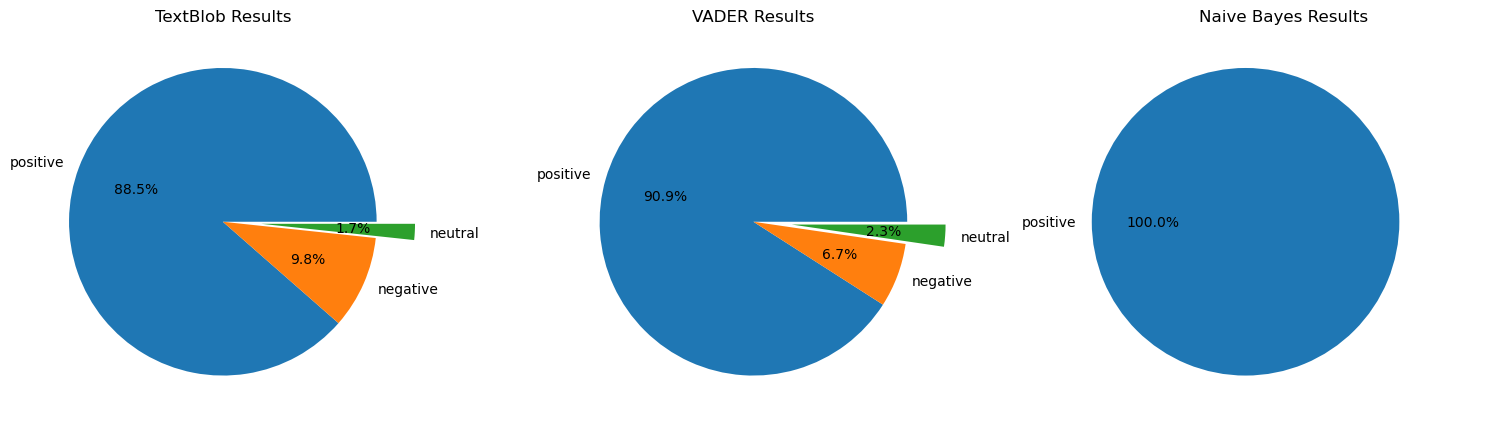

In [49]:
tb_counts = df["textblob_sentiment"].value_counts()
vader_counts = df["vader_sentiment"].value_counts()
nb_counts = df["nb_sentiment"].value_counts()

import matplotlib.pyplot as plt

# First, check how many categories each sentiment analysis has
print(f"TextBlob categories: {len(tb_counts)}")
print(f"VADER categories: {len(vader_counts)}")
print(f"Naive Bayes categories: {len(nb_counts)}")

# Then create a pie chart with dynamically sized explode tuples
plt.figure(figsize=(15,5))

# TextBlob sentiment pie chart
plt.subplot(1,3,1)
plt.title("TextBlob Results")
# Create explode tuple of the right length, with only the last element exploded
tb_explode = [0] * (len(tb_counts) - 1) + [0.25]
plt.pie(tb_counts.values, labels=tb_counts.index, explode=tb_explode, autopct='%1.1f%%', shadow=False)

# VADER sentiment pie chart
plt.subplot(1,3,2)
plt.title("VADER Results")
vader_explode = [0] * (len(vader_counts) - 1) + [0.25]
plt.pie(vader_counts.values, labels=vader_counts.index, explode=vader_explode, autopct='%1.1f%%', shadow=False)

# Naive Bayes sentiment pie chart
plt.subplot(1,3,3)
plt.title("Naive Bayes Results")
nb_explode = [0] * (len(nb_counts) - 1) + [0.25]
plt.pie(nb_counts.values, labels=nb_counts.index, explode=nb_explode, autopct='%1.1f%%', shadow=False)

plt.tight_layout()
plt.show()

In [51]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [53]:
# TextBlob accuracy
tb_accuracy = accuracy_score(df["true_sentiment"], df["textblob_sentiment"])
print("TextBlob Accuracy:", round(tb_accuracy * 100, 2), "%")

# Full classification report
print("TextBlob Report:")
print(classification_report(df["true_sentiment"], df["textblob_sentiment"]))

TextBlob Accuracy: 76.82 %
TextBlob Report:
              precision    recall  f1-score   support

    negative       0.55      0.63      0.59        95
     neutral       0.11      0.01      0.02       200
    positive       0.81      0.97      0.88       831

    accuracy                           0.77      1126
   macro avg       0.49      0.54      0.49      1126
weighted avg       0.66      0.77      0.70      1126



In [55]:
# VADER accuracy
vader_accuracy = accuracy_score(df["true_sentiment"], df["vader_sentiment"])
print("VADER Accuracy:", round(vader_accuracy * 100, 2), "%")

# Full classification report
print("VADER Report:")
print(classification_report(df["true_sentiment"], df["vader_sentiment"]))

VADER Accuracy: 76.55 %
VADER Report:
              precision    recall  f1-score   support

    negative       0.64      0.52      0.57        95
     neutral       0.27      0.04      0.06       200
    positive       0.79      0.97      0.87       831

    accuracy                           0.77      1126
   macro avg       0.57      0.51      0.50      1126
weighted avg       0.68      0.77      0.70      1126



In [57]:
# Naive Bayes accuracy
nb_accuracy = accuracy_score(df["true_sentiment"], df["nb_sentiment"])
print("Naive Bayes Accuracy:", round(nb_accuracy * 100, 2), "%")

# Full classification report with zero_division parameter
print("Naive Bayes Report:")
print(classification_report(df["true_sentiment"], df["nb_sentiment"], zero_division=0))

Naive Bayes Accuracy: 73.8 %
Naive Bayes Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        95
     neutral       0.00      0.00      0.00       200
    positive       0.74      1.00      0.85       831

    accuracy                           0.74      1126
   macro avg       0.25      0.33      0.28      1126
weighted avg       0.54      0.74      0.63      1126



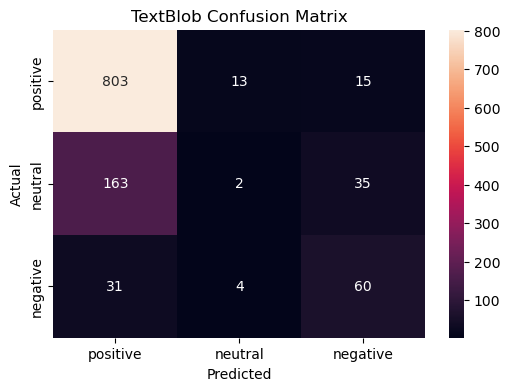

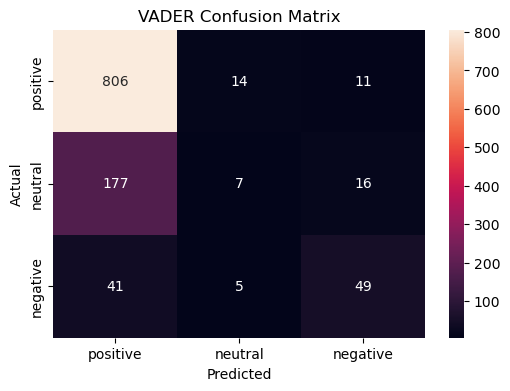

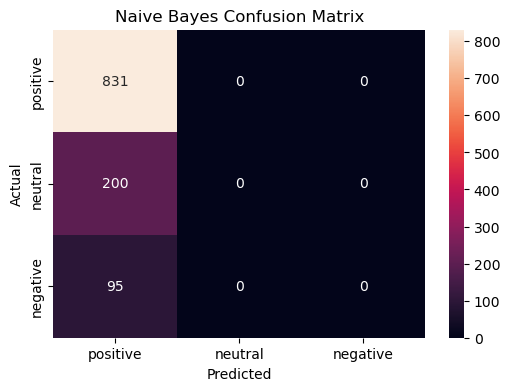

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# TextBlob Confusion Matrix
tb_cm = confusion_matrix(df["true_sentiment"], df["textblob_sentiment"], labels=["positive", "neutral", "negative"])
plt.figure(figsize=(6,4))
sns.heatmap(tb_cm, annot=True, fmt='d', xticklabels=["positive", "neutral", "negative"], yticklabels=["positive", "neutral", "negative"])
plt.title("TextBlob Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# VADER Confusion Matrix
vader_cm = confusion_matrix(df["true_sentiment"], df["vader_sentiment"], labels=["positive", "neutral", "negative"])
plt.figure(figsize=(6,4))
sns.heatmap(vader_cm, annot=True, fmt='d', xticklabels=["positive", "neutral", "negative"], yticklabels=["positive", "neutral", "negative"])
plt.title("VADER Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Naive Bayes Confusion Matrix
vader_cm = confusion_matrix(df["true_sentiment"], df["nb_sentiment"], labels=["positive", "neutral", "negative"])
plt.figure(figsize=(6,4))
sns.heatmap(vader_cm, annot=True, fmt='d', xticklabels=["positive", "neutral", "negative"], yticklabels=["positive", "neutral", "negative"])
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [61]:
# Export the DataFrame to a new CSV file
output_file_path = "sentiment_analysis_reviews.csv"
df.to_csv(output_file_path, index=False)

print(f"File saved as {output_file_path}")


File saved as sentiment_analysis_reviews.csv
